In [1]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from sklearn.utils import shuffle


In [2]:
df=pd.read_csv('prepared_data.csv')

In [3]:
df.head()

,Document ID,Department,class_ids,text_file
0,8366374,Administration,0,Comapany Name is Heraa international travel s...
1,8125246,Administration,0,Alliance Recruitment AgencyComapany Name is Al...
2,8203166,Administration,0,Comapany Name is Jobtrack Management Services...
3,8203252,Administration,0,Comapany Name is Jobtrack Management Services...
4,8394452,Administration,0,Comapany Name is T.Y. Tours &amp; Travels.Job...


In [4]:
df=shuffle(df)

In [5]:
df.head()

,Document ID,Department,class_ids,text_file
541,8008822,Sales,27,"Colorful Vacations provide travel, tourism rel..."
448,8370880,Marketing,19,Comapany Name is Conde Nast India.Job keyword...
88,8115383,Customer service,5,Thank you for giving us an opportunity to pres...
107,7930630,Customer service,5,Comapany Name is Magic Holidays Ltd..Job keyw...
1135,8041960,Ticketing,29,We are the Direct Recruiter for the Hiring Com...


### **# Now lets clean our data like removal of useless attributes and text preprocessing.**





In [6]:
df1=df[['class_ids', 'text_file']] 
df1=df1.reset_index()

In [7]:
df1.head()

,index,class_ids,text_file
0,541,27,"Colorful Vacations provide travel, tourism rel..."
1,448,19,Comapany Name is Conde Nast India.Job keyword...
2,88,5,Thank you for giving us an opportunity to pres...
3,107,5,Comapany Name is Magic Holidays Ltd..Job keyw...
4,1135,29,We are the Direct Recruiter for the Hiring Com...


In [8]:
df1['class_ids'].value_counts()

29    347
27    270
7     151
5      69
19     50
9      42
20     41
0      38
14     28
11     20
3      18
15     12
28     10
21     10
2       9
8       7
25      6
4       6
23      5
1       4
17      3
13      3
16      2
18      2
24      2
6       2
10      2
12      1
22      1
26      1
Name: class_ids, dtype: int64

In [11]:
df1=df1[df1['class_ids']!=26] #removed categories with single files only as they will give error while splitting

In [12]:
df1['text_file'] = df1['text_file'].str.replace("[^a-zA-Z]", " ")


In [19]:
df1.head()

,class_ids,text_file
0,27,Colorful Vacations provide travel tourism rel...
1,19,Comapany Name is Conde Nast India Job keyword...
2,5,Thank you for giving us an opportunity to pres...
3,5,Comapany Name is Magic Holidays Ltd Job keyw...
4,29,We are the Direct Recruiter for the Hiring Com...


In [17]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/anshul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df1.head()

,class_ids,text_file
0,27,Colorful Vacations provide travel tourism rel...
1,19,Comapany Name is Conde Nast India Job keyword...
2,5,Thank you for giving us an opportunity to pres...
3,5,Comapany Name is Magic Holidays Ltd Job keyw...
4,29,We are the Direct Recruiter for the Hiring Com...


In [28]:
tokenized_doc = df1['text_file'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df1)): 
    t = ' '.join(tokenized_doc.iloc[i]) 
    detokenized_doc.append(t) 

df1['text_file'] = detokenized_doc

In [29]:
df1['text_file'] #can use multiple preprocessing steps too like stemming and lemmatization but our text does not need that.

0       Colorful Vacations provide travel tourism rela...
1       Comapany Name Conde Nast India Job keywords Br...
2       Thank giving us opportunity present nbsp Integ...
3       Comapany Name Magic Holidays Ltd Job keywords ...
4       We Direct Recruiter Hiring Company big entity ...
5       Post HELPER DRIVER SUPERVISOR STORE KEEPER PL ...
6       Welcome Harry International ISO Certified Cons...
7       Colorful Vacations provide travel tourism rela...
8       Pack N Go Holidays Pvt LtdPack N Go Holidays p...
9       We fast growing worldwide travel amp tourism c...
10      Comapany Name Unique World Job keywords Amadeu...
11      A furious welcome Hosanna Tours Travels one st...
12      Comapany Name ResBird Technologies Pvt Ltd Ama...
13      Global Placement professionally managed Manpow...
14      We established recruitment firm providing manp...
15      Sky EnterprisesComapany Name Company Hidden Jo...
16      cmts engaged data entry outsourcing supply ski...
17      Colorf

In [30]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['class_ids'], test_size = 0.2, random_state = 12)

In [31]:
df_val['class_ids'].value_counts()

29    70
27    54
7     30
5     14
19    10
9      9
0      8
20     8
14     6
11     4
3      4
15     2
28     2
21     2
2      2
17     1
8      1
23     1
25     1
4      1
1      1
13     1
Name: class_ids, dtype: int64

In [32]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [42]:
learn = language_model_learner(data_lm,drop_mult=0.7,arch=AWD_LSTM)


In [43]:
learn.fit_one_cycle(1, 1e-2) #language model training


epoch,train_loss,valid_loss,accuracy,time
0,5.421116,4.069749,0.384213,00:12


In [44]:
learn.save_encoder('ft_enc')


In [45]:
#Let’s now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder.
learn = text_classifier_learner(data_clas,arch=AWD_LSTM,drop_mult=0.7)
learn.load_encoder('ft_enc')

In [48]:
learn.fit_one_cycle(100, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,1.689908,1.425121,0.564655,00:13
1,1.639701,1.410841,0.568965,00:12
2,1.683555,1.427429,0.556035,00:13
3,1.703182,1.417194,0.560345,00:12
4,1.702340,1.429083,0.556035,00:13
5,1.699256,1.424054,0.594828,00:13
6,1.687587,1.441860,0.560345,00:12
7,1.678581,1.415530,0.590517,00:13
8,1.687046,1.442312,0.590517,00:13
9,1.690141,1.441033,0.603448,00:13


In [49]:
interp = ClassificationInterpretation.from_learner(learn)


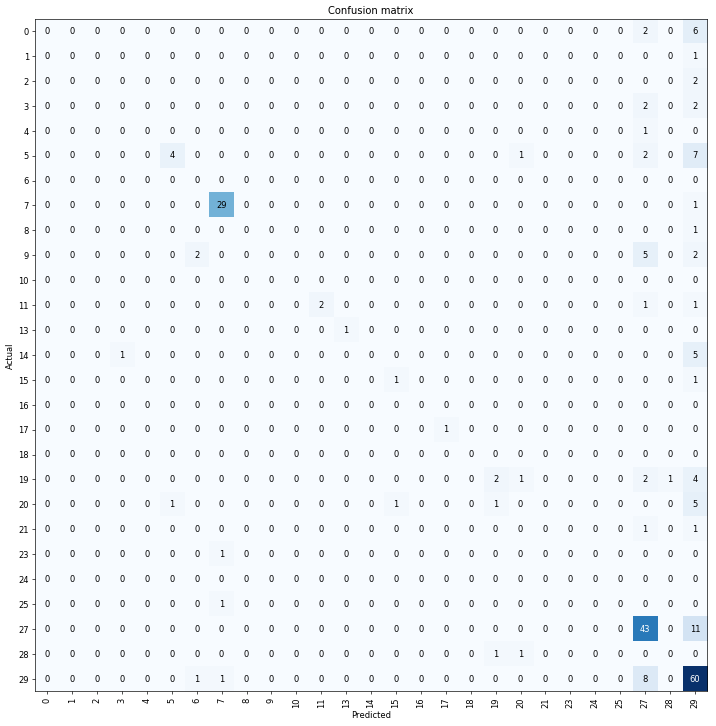

In [51]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [52]:
interp.most_confused(min_val=2) #most misclassifications


[(27, 29, 11),
 (29, 27, 8),
 (5, 29, 7),
 (0, 29, 6),
 (9, 27, 5),
 (14, 29, 5),
 (20, 29, 5),
 (19, 29, 4),
 (0, 27, 2),
 (2, 29, 2),
 (3, 27, 2),
 (3, 29, 2),
 (5, 27, 2),
 (9, 6, 2),
 (9, 29, 2),
 (19, 27, 2)]

Most of misclassifications belong to class 27('Sales') and 29('Ticketing') because of class imbalance,could be improved with more data available for other classes too. 